# SYS 611: SimPy Tutorial

Paul T. Grogan <pgrogan@stevens.edu>

This example introduces SimPy based on the [SimPy in 10 Minutes](https://simpy.readthedocs.io/en/latest/simpy_intro/index.html) tutorial.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `matplotlib.pyplot` and `simpy` libraries. SimPy is not a standard library included in most Python distributions. The `!pip install simpy` command below attempts to install it using the pip package management system.

In [1]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the matplotlib.pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

# try to install the simpy package
! pip install simpy

# import the simpy package 
import simpy

## Step 1: Simulator with One Process

SimPy uses a Python feature called a *generator* to define simulation processes. The example below defines a process `car_run` that models a car that alternates between spending 5.0 hours in the driving state  (1) and 2.0 hours in a parked state (0). The `yield` keyword with the environment's `timeout` method allows a simulator to evaluate other processes while waiting.

To set up a simulation, a SimPy `Environment` object must first be created. Two arrays (`t` and `q`) will store state trajectories for time and vehicle state (0: parked, 1: driving). An instance of the `car_run` process can be added to the environment using the `process` method. Finally, the simulation environment can execute using the `run` function until a threshold time.

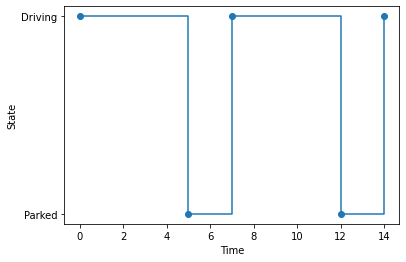

In [2]:
def car_run(env, t, q):
    # enter an infinite loop
    while True:
        # enter driving state
        t.append(env.now)
        q.append(1)
        
        # wait for 5.0 hours
        yield env.timeout(5.0)
        
        # enter parked state
        t.append(env.now)
        q.append(0)
        
        # wait for 2.0 hours
        yield env.timeout(2.0)

# create the simulation environment
env = simpy.Environment()

# create arrays to store state trajectories
t = []
q = []

# add a new car process to the environment
env.process(car_run(env, t, q))

# run the simulation for 15.0 hours
env.run(until=15.0)

# plot the results
plt.figure()
plt.step(t, q, 'o-', where='post')
plt.xlabel('Time')
plt.ylabel('State')
plt.yticks([0,1], ['Parked', 'Driving'])
plt.show()

## Step 2: Simulator with Multiple Independent Processes

Scaling up a simulation to consider multiple parallel processes is easy. This example refactors the `car_run` process to accept some additional arguments to customize its behavior for different cars. Then, two processes (representing two cars) are added to the SimPy environment before running the simulation. Results record state trajectories for each vehicle for plotting.

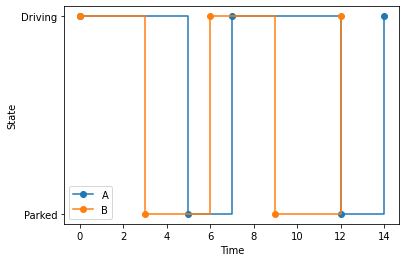

In [3]:
def car_run(env, t, q, t_drive, t_park):
    # append initial time and state
    t.append(env.now)
    q.append(1)
    
    # enter an infinite loop
    while True:
        # wait for t_drive
        yield env.timeout(t_drive)
        
        # enter parked state
        t.append(env.now)
        q.append(0)
        
        # wait for t_park
        yield env.timeout(t_park)
        
        # enter driving state
        t.append(env.now)
        q.append(1)

# create the simulation environment
env = simpy.Environment()

# create arrays to store state trajectories for two cars
t1 = []
q1 = []
t2 = []
q2 = []

# add two new car process to the environment
env.process(car_run(env, t1, q1, 5.0, 2.0))
env.process(car_run(env, t2, q2, 3.0, 3.0))

# run the simulation for 15.0 hours
env.run(until=15.0)

# plot the results
plt.figure()
plt.step(t1, q1, 'o-', where='post', label='A')
plt.step(t2, q2, 'o-', where='post', label='B')
plt.xlabel('Time')
plt.ylabel('State')
plt.yticks([0,1], ['Parked', 'Driving'])
plt.legend()
plt.show()

## Step 3: Simulator with Multiple Independent Nested Processes

Processes do not need to be defined in a single generator expression. Sometimes it may be helpful to break up into smaller components. This example decomposes the `car_run` process into two sub-processes: `car_drive` and `car_park` which may make the simulation easier to understand from a human perspective---it does not change numerical results.

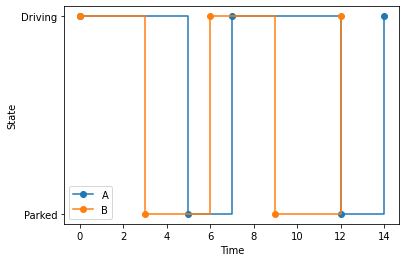

In [4]:
def car_run(env, t, q, t_drive, t_park):    
    while True:
        # wait for a driving process to complete
        yield env.process(car_drive(env, t, q, t_drive))
        # wait for a parking process to complete
        yield env.process(car_park(env, t, q, t_park))

def car_drive(env, t, q, t_drive):
    # enter driving state
    t.append(env.now)
    q.append(1)
    # wait for t_drive
    yield env.timeout(t_drive)

def car_park(env, t, q, t_park):
    # enter parked state
    t.append(env.now)
    q.append(0)
    # wait for t_park
    yield env.timeout(t_park)

# create the simulation environment
env = simpy.Environment()

# create arrays to store state trajectories
t1 = []
q1 = []
t2 = []
q2 = []

# add a new car process to the environment
env.process(car_run(env, t1, q1, 5.0, 2.0))
env.process(car_run(env, t2, q2, 3.0, 3.0))

# run the simulation for 15.0 hours
env.run(until=15.0)

# plot the results
plt.figure()
plt.step(t1, q1, 'o-', where='post', label='A')
plt.step(t2, q2, 'o-', where='post', label='B')
plt.xlabel('Time')
plt.ylabel('State')
plt.yticks([0,1], ['Parked', 'Driving'])
plt.legend()
plt.show()

## Step 4: Simulator with Multiple Interacting Processes

The true power of process-oriented discrete event simulation arises when processes can interact with each other. This example models a parking lot with a single parking spot, such that only one car can be parked at a time.

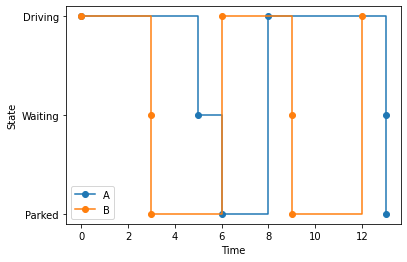

In [5]:
def car_run(env, lot, t, q, t_drive, t_park):    
    while True:
        # drive
        yield env.process(car_drive(env, t, q, t_drive))
        # request parking
        with lot.request() as request:
            # enter waiting state
            t.append(env.now)
            q.append(0.5)
            # wait for the request
            yield request
            # park
            yield env.process(car_park(env, t, q, t_park))

def car_drive(env, t, q, t_drive):
    # enter driving state
    t.append(env.now)
    q.append(1)
    # wait for t_drive
    yield env.timeout(t_drive)

def car_park(env, t, q, t_park):
    # enter parked state
    t.append(env.now)
    q.append(0)
    # wait for t_park
    yield env.timeout(t_park)

# create the simulation environment
env = simpy.Environment()

# create a resource (parking lot) with one capacity
lot = simpy.Resource(env, capacity=1)

# create arrays to store state trajectories
t1 = []
q1 = []
t2 = []
q2 = []    

# add a new car process to the environment
env.process(car_run(env, lot, t1, q1, 5.0, 2.0))
env.process(car_run(env, lot, t2, q2, 3.0, 3.0))

# run the simulation for 15.0 hours
env.run(until=15.0)

# plot the results
plt.figure()
plt.step(t1, q1, 'o-', where='post', label='A')
plt.step(t2, q2, 'o-', where='post', label='B')
plt.xlabel('Time')
plt.ylabel('State')
plt.yticks([0,0.5,1], ['Parked', 'Waiting', 'Driving'])
plt.legend()
plt.show()

## Step 5: Simulator with Multiple Interacting Processes

SimPy has many features to model processes. This last example models an electric charging station at the parking lot with a minimum charge time.

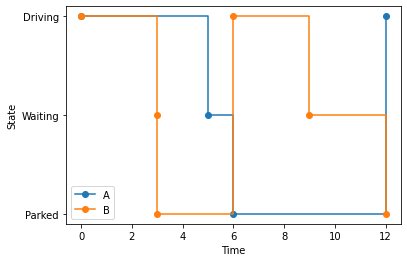

In [6]:
def car_run(env, lot, t, q, t_drive, t_park, t_charge):    
    while True:
        # drive
        yield env.process(car_drive(env, t, q, t_drive))
        # request parking
        with lot.request() as request:
            # enter waiting state
            t.append(env.now)
            q.append(0.5)
            # wait for the request
            yield request
            parking = env.process(car_park(env, t, q, t_park))
            charging = env.process(car_charge(env, t_charge))
            # wait for parking and charging 
            yield parking & charging

def car_drive(env, t, q, t_drive):
    # enter driving state
    t.append(env.now)
    q.append(1)
    # wait for t_drive
    yield env.timeout(t_drive)

def car_park(env, t, q, t_park):
    # enter parked state
    t.append(env.now)
    q.append(0)
    # wait for t_park
    yield env.timeout(t_park)

def car_charge(env, t_charge):
    # wait for t_charge
    yield env.timeout(t_charge)

# create the simulation environment
env = simpy.Environment()

# create a resource with one capacity
lot = simpy.Resource(env, capacity=1)

# create arrays to store state trajectories
t1 = []
q1 = []
t2 = []
q2 = []

# add a new car process to the environment
env.process(car_run(env, lot, t1, q1, 5.0, 2.0, 6.0))
env.process(car_run(env, lot, t2, q2, 3.0, 3.0, 2.0))

# run the simulation for 15.0 hours
env.run(until=15.0)

# plot the results
plt.figure()
plt.step(t1, q1, 'o-', where='post', label='A')
plt.step(t2, q2, 'o-', where='post', label='B')
plt.xlabel('Time')
plt.ylabel('State')
plt.yticks([0,0.5,1], ['Parked', 'Waiting', 'Driving'])
plt.legend()
plt.show()